## Training a model and its know-how

### 1. Tuning the Model on Test-set

In general, dataset is split into a train-set and test-set
- train-set: be utilized to fit the model
- test-set: be utilized to test the performance of the model

The purpose of the utilization of Test-set is to avoid building a model that only fits to the specific dataset

#### 1-1. Creating a Logistic Regression model

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

In [2]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

The accuracy of the testset is 83%.

In the case, the accuracy is not prefarable, other Loss Functions could be replaced to its original Loss Function, *log loss function*

#### 1-2. Check if the performance gets improved by changing the loss function
- change from **Logistic Regression (Log Loss Function)** to **SVM (Hinge Loss Function)**

In [3]:
sgd = SGDClassifier(loss = 'hinge', random_state = 42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.9385964912280702

The performance gets better.

In the case of the model does not perform as expected, you can change the loss function to others.

This procedure is called **_Tuning a model_**

**However**, if you tune the model on the test-set, the model works better only on the test-set

- It is expressed _"the information of the test-set is leaked"_

**Therefore,** it is hard to generalize the model

### 2. Preparing a Validate-set

How to tune the model, then?

Tune the model on validate-set

- validate-set: a small amount of the train-set

#### 2-1. Splitting dataset into Train-set and Test-set

In [4]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
print('x original:',x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
print('x_train:', x_train.shape, '\tx_test:',x_test.shape)
print('y_train:', y_train.shape, '\ty_test:', y_test.shape)

x original: (569, 30)
x_train: (455, 30) 	x_test: (114, 30)
y_train: (455,) 	y_test: (114,)


original data is split into 455 train-set and 114 test-set

In [5]:
455 + 114

569

#### 2-2. Splitting the Train-set into train_set and validate_set

In [6]:
new_x_train, x_validate, new_y_train, y_validate = train_test_split(x_train, y_train, stratify = y_train, 
                                                                    test_size = 0.2, random_state = 42)
print('x_train:', x_train.shape)
print('new_x_train:', new_x_train.shape, '\tx_validate:',x_validate.shape)
print('new_y_train:', new_y_train.shape, '\ty_validate:', y_validate.shape)

x_train: (455, 30)
new_x_train: (364, 30) 	x_validate: (91, 30)
new_y_train: (364,) 	y_validate: (91,)


x_train is split into 364 new_x_train-set and 91 x_validate-set

In [7]:
364 + 91

455

#### 2-3. Check the performance of the model by tuning on validate-set

In [8]:
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(new_x_train, new_y_train)
sgd.score(x_validate, y_validate)

0.6923076923076923

OOOOOPS, the performance gets worse

Why?

The amount of the data-set is pretty small..

**Therefore**, 

- when the amount of the dataset is over 100,000, split the data into 8:1:1
- when the amount of the dataset is over 1,000,000, split the data into 98:1:1

### 3. Data Preprocessing and Scalling

Gradient Descent is very sensitive to the scale
- **thus**, you need to scale before modeling

#### 3-1. Example of the performance on un-scale-data
- as an example, feature 3 and feature 4 will be utilized
- since their scales are too different

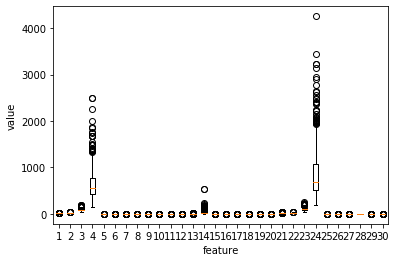

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

['mean perimeter' 'mean area']


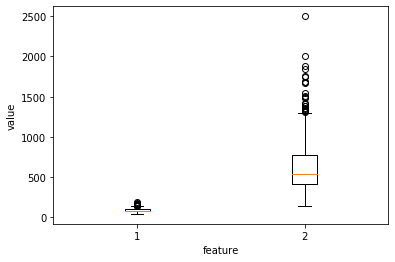

In [10]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

#### 3-2. Gradient Descent on the un-scaled-data

learning_rate: the amount of the weight update (log scale is generally used: 0.001, 0.01, etc..)
- large lr: high risk to pass global minimum
- small lr: high cost for learning a model
- proper lr: no chance to pass the global minumum but work pretty fast

### 4. Single Layer with learning rate

In [11]:
import numpy as np

In [12]:
class SingleLayerLR:
    def __init__(self, learning_rate = 0.1):
        self.w = None                                                 # initiate a weight
        self.b = None                                                 # initiate a bias
        self.loss = []                                                # append a loss
        self.w_history = []                                           # append learning_rate
        self.lr = learning_rate

    def fwrd(self, x):
        z = np.sum(x * self.w + self.b)
        return z

    def bwrd(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])                                  # initiate a weight
        self.b = 0                                                    # initiage a bias
        self.w_history.append(self.w.copy())                          # record the weight

        for i in range(epochs):                                       # iterate the learning as many as the size of the epochs
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))        # shuffle the index
            for i in indexes:                                         # interate for all samples
                z = self.fwrd(x[i])                                   # forward
                a = self.activation(z)                                # activation
                err = - (y[i] - a)                                    # compute the error
                w_grad, b_grad = self.bwrd(x[i], err)                 # backward
                self.w -= self.lr * w_grad                            # update the weight
                self.b -= b_grad                                      # update the bias
                self.w_history.append(self.w.copy())                  # record the wieght
                a = np.clip(a, 1e-10, 1-1e-10)                        # range setting for a safe log calculation
                loss += -(y[i] * np.log(a) + (1-y[i]) * np.log(1- a)) # update the loss
            self.loss.append(loss / len(y))                           # record loss every epoch

    def predict(self, x):
        z = [self.fwrd(xi) for xi in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [13]:
layer = SingleLayerLR()
layer.fit(new_x_train, new_y_train)
layer.score(x_validate, y_validate)

0.9120879120879121

#### 4-1. Check How the Learning Rate has changed

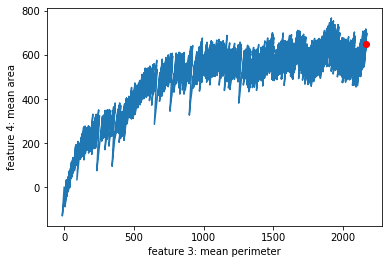

In [14]:
lst1 = []
lst2 = []
for w in layer.w_history:
    lst1.append(w[2])
    lst2.append(w[3])
plt.plot(lst1, lst2)
plt.plot(lst1[-1], lst2[-1], 'ro')
plt.xlabel('feature 3: mean perimeter')
plt.ylabel('feature 4: mean area')
plt.show()

as seen in the plot, 

since the scale of the *mean area* is greater than *mean perimeter*, **mean area is highly fluctuating during the learning**

**Thus**, it is unstable to find an optimum

#### 4-2. Learning by adjusting a scale
- Standardization $$z = \frac{(x-\mu)}{s}$$


In [15]:
train_mean = np.mean(new_x_train, axis = 0)
train_std = np.std(new_x_train, axis = 0)
x_train_scaled = (new_x_train - train_mean) / train_std

#### 4-3. Modeling

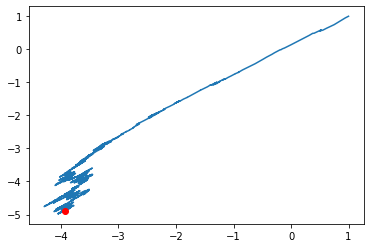

In [16]:
layer2 = SingleLayerLR()
layer2.fit(x_train_scaled, new_y_train)
lst1 = []
lst2 = []
for w in layer2.w_history:
    lst1.append(w[2])
    lst2.append(w[3])
plt.plot(lst1, lst2)
plt.plot(lst1[-1], lst2[-1], 'ro')
plt.show()

Since the scale of two feature are similar, their weight moves like the diagnal line

#### 4-4. Performance

In [17]:
layer2.score(x_validate, y_validate)

0.37362637362637363

Why the performance is bad?
- Only changed the scales of the train-set
- **Therefore**, change the scales of the Validate-set too

#### 4-5. Scaling the validate-set

In [18]:
val_mean = np.mean(x_validate, axis = 0)
val_std = np.std(x_validate, axis=  0)
x_validate_scaled = (x_validate - val_mean) / val_std
layer2.score(x_validate_scaled, y_validate)

0.978021978021978

### 5. The Common Mistake of the Scaling train-set and validate-set

#### 5-1. original x_train and x_validate plot

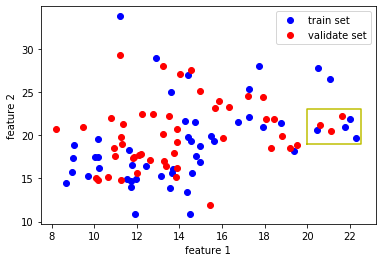

In [19]:
plt.plot(new_x_train[:50, 0], new_x_train[:50, 1], 'bo')
plt.plot(x_validate[:50, 0], x_validate[:50, 1], 'ro')
plt.plot([20,20,22.5, 22.5, 20],[19,23,23,19,19], 'y')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'validate set'])
plt.show()

#### 5-2. scaled x_train and x_validate plot

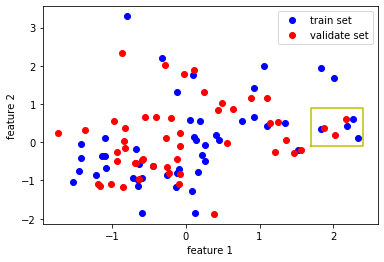

In [20]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_validate_scaled[:50, 0], x_validate_scaled[:50, 1], 'ro')
plt.plot([1.7,1.7, 2.4, 2.4, 1.7],[-0.1,0.9,0.9,-0.1,-0.1], 'y')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'validate set'])
plt.show()

#### 5-3. Mistakes and tricks

the distributions of the plots are supposed to be tatally same after scaling too
- the yellow squared box showed that the dots are little bit different and other points are slightly different

Why is it that?
- Because scaled with different ratio
- **therefore**, when you scaled train and validate sets, scale with the same ratio
- **thus**, use **train_mean** and **train_std** when scaling on validate-set

[4-5] implemented as follow:

val_mean = np.mean(x_validate, axis = 0)

val_std = np.std(x_validate, axis=  0)

x_validate_scaled = (x_validate - val_mean) / val_std

layer2.score(x_validate_scaled, y_validate)

#### 5-4. RIGHT WAY to scale the validate-set

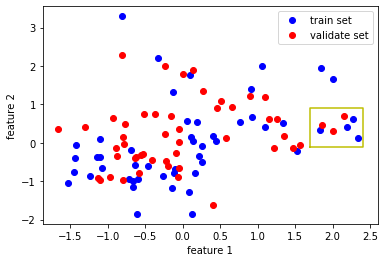

In [21]:
x_val_scaled = (x_validate - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.plot([1.7,1.7, 2.4, 2.4, 1.7],[-0.1,0.9,0.9,-0.1,-0.1], 'y')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'validate set'])
plt.show()

now, the dots in the yellow box are the same from the yellow box at [5-1]

#### 5-5. Performance
- comapre with the score at [4-5]
- should be the same since the amount of the dataset is pretty small
- if you have a bigger dataset, the result would be slightly different

In [22]:
layer2.score(x_val_scaled, y_validate)

0.978021978021978